### **Imports**

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from poetry_project.pipeline import load_authors_database, compute_author_metrics
from poetry_project.utils.persistence import clean_authors_dataset
from poetry_project.utils.linguistic_utils import adjectives_plus_adverbs_ratio
from poetry_project.utils.rhyme_utils import poem_has_rhymes
from poetry_project.utils.analysis_utils import (compute_country_stats, 
                                                 most_common_words, 
                                                 detect_trendy_words, 
                                                 rhyme_density_local_all_words)
from poetry_project.analysis.visualizations import (compare_poets_radar,
                                                    scatter_authors_by_metrics,
                                                    plot_correlation_heatmap,
                                                    plot_metric_distribution,
                                                    plot_word_trend,
                                                    boxplot_poem_lengths,
                                                    plot_trend_with_lowess)

### **Load data**

In [4]:
# Load persisted authors and metrics
authors = load_authors_database()
authors = clean_authors_dataset(authors)
metrics_df = compute_author_metrics(authors)

print(f"Loaded {len(authors)} authors")
metrics_df.head()

Loaded 112 authors


,author,birth_year,nationality,avg_poem_length,end_line_rhyme_poems_pct,poem_count,constant_syllable_pct,avg_rhyme_density_all_words,avg_adj_adv_ratio,lexical_mtld
0,Adrienne Rich,1929,United States,38.277778,0.000000,18,22.222222,0.098263,0.093120,627.429091
1,Alexander Pope,1688,United Kingdom,76.181818,81.818182,11,18.181818,0.267124,0.140240,629.135862
2,Amanda Gorman,1998,United States,72.076923,7.692308,13,7.692308,0.159987,0.084208,485.737412
3,Amy Lowell,1874,United States,97.909091,27.272727,11,0.000000,0.197099,0.123666,623.989921
4,Andrew Marvell,1621,England,106.571429,78.571429,14,14.285714,0.290957,0.130986,658.173567


##### Column descriptions for `metrics_df`

##### The table below explains the meaning of each column in the author metrics DataFrame.

| Column | Meaning |
|--------|---------|
| **author** | Full name of the poet. |
| **birth_year** | Year of birth (integer) as retrieved from Wikidata. |
| **nationality** | Country of citizenship |
| **avg_poem_length** | Average number of words per poem for that author. |
| **end_line_rhyme_poems_pct** | Percentage of the author’s poems that use end‑line rhymes. |
| **poem_count** | Total number of poems collected for that author. |
| **constant_syllable_pct** | Percentage of poems where every line has the same syllable count (indicative of strict meter). |
| **avg_rhyme_density_all_words** | Average proportion of words in a poem that rhyme with another word within a short window of lines (local rhyme density). |
| **avg_adj_adv_ratio** | Average ratio of adjectives and adverbs to total words in the author’s poems — a proxy for descriptive intensity. |
| **lexical_mtld** | Measure of Textual Lexical Diversity (MTLD), a length‑robust vocabulary richness score. |

### **Simple statistics about the dataset**

In [5]:
# Total number of poems
total_poems = sum(len(a.poems) for a in authors)
print(f"Total number of poems: {total_poems}")

# Poems divided by nationality
nationality_counts = compute_country_stats(authors, metrics_df)
display(nationality_counts.head())

Total number of poems: 2944


,Poets,Total Poems,Authors Avg Birth Year,Avg Poem Length,Avg Adjective + Adverb Ratio,Avg Rhyme Density,Constant Syllable %
nationality,,,,,,,
United States,40,941,1899,61.56,0.11,0.16,6.47
United Kingdom,38,1296,1815,79.86,0.12,0.22,5.89
Ireland,9,202,1909,49.95,0.11,0.15,6.73
India,2,39,1950,55.27,0.10,0.15,10.88
Canada,2,42,1925,56.92,0.12,0.11,9.03


##### *Clarification: We consider the countries that currently make up the United Kingdom to be members of the UK, regardless of their membership during the poet's lifetime.*

### **Poets comparison**

#### **Information**

In [6]:
# Choose two poets
poet_a = "William Wordsworth"
poet_b = "Samuel Taylor Coleridge"

# Basic info from Author objects
for poet in (poet_a, poet_b):
    author_obj = next(a for a in authors if a.name == poet)
    print(f"{author_obj.name} — Birth year: {author_obj.birth_year}, Nationality: {author_obj.nationality}, Poems: {len(author_obj.poems)}")

William Wordsworth — Birth year: 1770, Nationality: United Kingdom, Poems: 46
Samuel Taylor Coleridge — Birth year: 1772, Nationality: United Kingdom, Poems: 27


#### **Most common words used by each poet**

In [7]:
common_a = most_common_words([a for a in authors if a.name == poet_a], top_n=10)
common_b = most_common_words([a for a in authors if a.name == poet_b], top_n=10)

print(f"Most common words for {poet_a}:")
display(common_a)

print(f"Most common word for {poet_b}:")
display(common_b)

Most common words for William Wordsworth:


,word,count
0,man,25
1,like,20
2,heart,17
3,thee,16
4,thou,14
5,thy,14
6,love,13
7,day,13
8,see,13
9,year,12


Most common word for Samuel Taylor Coleridge:


,word,count
0,long,11
1,thy,10
2,sea,9
3,love,9
4,thou,9
5,eye,9
6,light,7
7,like,7
8,soul,7
9,tell,7


#### **Radar chart comparison**

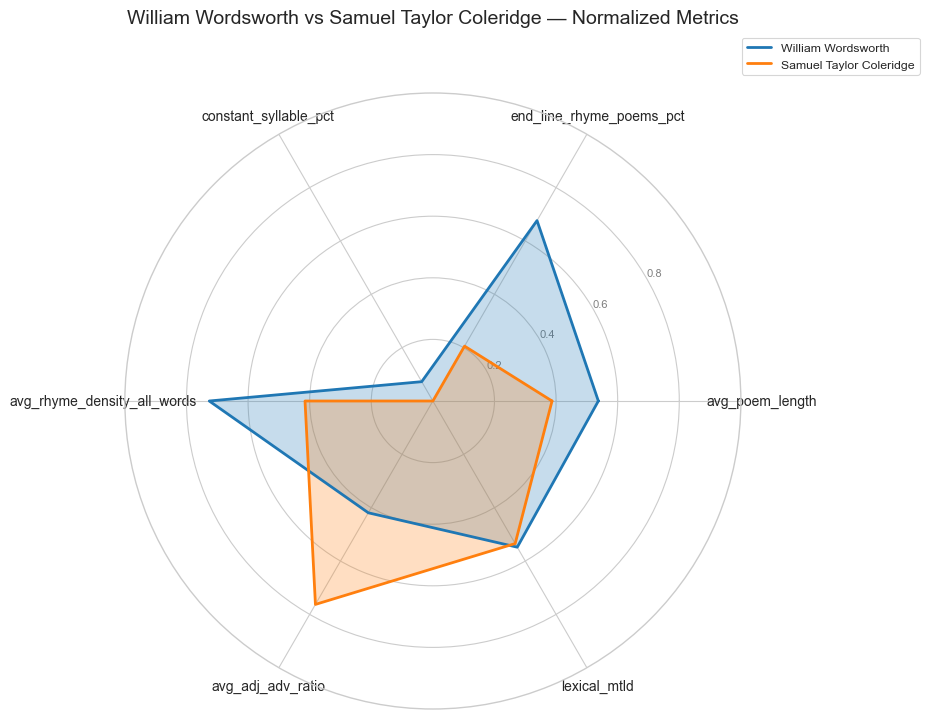

In [8]:
compare_poets_radar(metrics_df, poet_a, poet_b, title=f"{poet_a} vs {poet_b} — Normalized Metrics", show_average=False)

### **Shakespeare analysis**

In [9]:
# Find the Author object
shakespeare = next(a for a in authors if a.name == "William Shakespeare")
print(shakespeare)

William Shakespeare — Birth year: 1564 | Nationality: England | Poems in database: 173


#### **Poem example - Sonnet 73**

In [10]:
poem = shakespeare.get_poem_by_title("Sonnet 73")
number_of_adj_plus_adv, adj_adv_ratio = adjectives_plus_adverbs_ratio(poem)
rhyme_density = rhyme_density_local_all_words(poem)

print(f"{poem}\n")
print(f"{poem.content}\n")
print(f"Number of words: {poem.number_of_words}")
print(f"Number of lines: {poem.number_of_lines}")
print(f"Syllables structure: {poem.number_of_syllables_in_lines}")
print(f"Rhyme density: {rhyme_density}")
print(f"Poem has endline rhymes: {poem_has_rhymes(poem)}")

"Sonnet 73" by William Shakespeare

That time of year thou mayst in me  behold
When yel low leaves , or none , or few , do hang
U pon those boughs which shake a gainst the cold ,
Bare ru ined choirs , where late the sweet birds sang .
In me thou see'st the twi light of such day
As af ter sun set fad eth in the west ;
Which by and by black night doth take  away ,
Death's sec ond self , that seals up all in rest .
In me thou see'st the glow ing of such fire ,
That on the ash es of his youth doth lie ,
As the death - bed , where on it must ex pire ,
Con sumed with that which it was nour ish'd by .
This thou per ceiv'st , which makes thy love more strong ,
To love that well , which thou must leave ere long .

Number of words: 158
Number of lines: 14
Syllables structure: [10, 10, 10, 11, 11, 10, 10, 11, 12, 10, 11, 12, 11, 10]
Rhyme density: 0.2753623188405797
Poem has endline rhymes: True


#### **Radar chart**

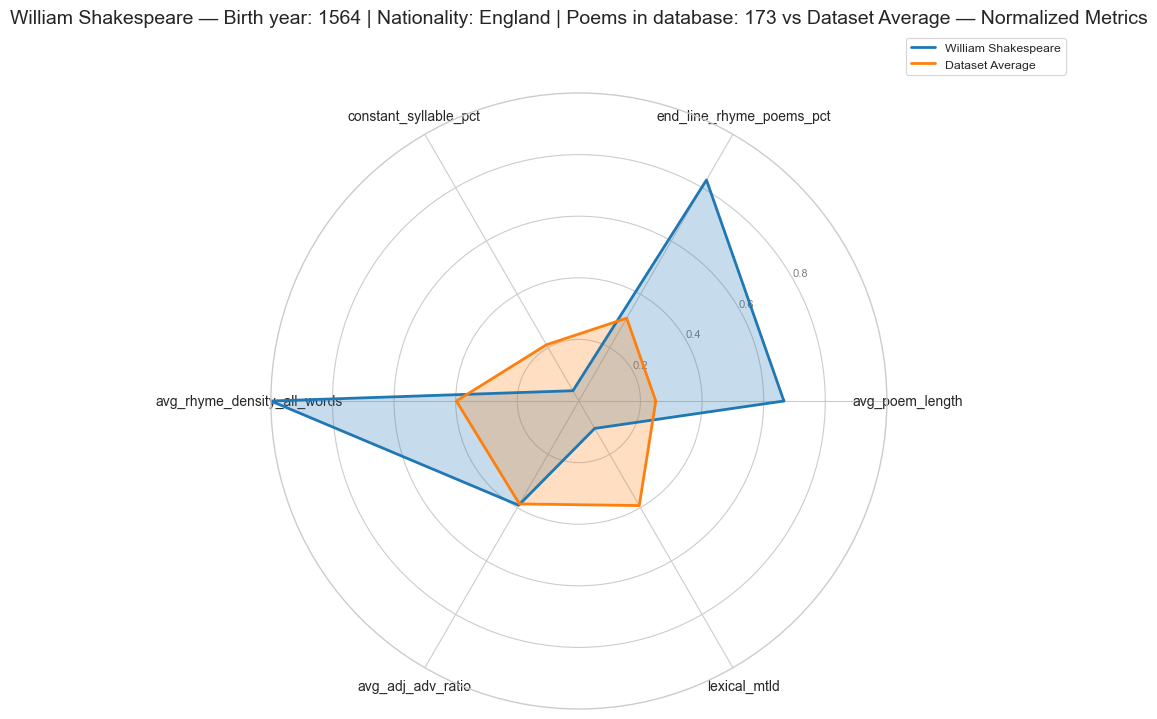

In [11]:
compare_poets_radar(metrics_df, "William Shakespeare", title=f"{shakespeare} vs Dataset Average — Normalized Metrics")

#### **Conclusions:** William Shakespeare used many more rhymes and wrote longer poems than the average poet. However, the MTLD coefficient, which measures vocabulary richness, was lower for Shakespeare, which may indicate that he often used repetitive words throughout his works.

### **Analysis of the whole dataset**

#### **Poem lengths analysis**

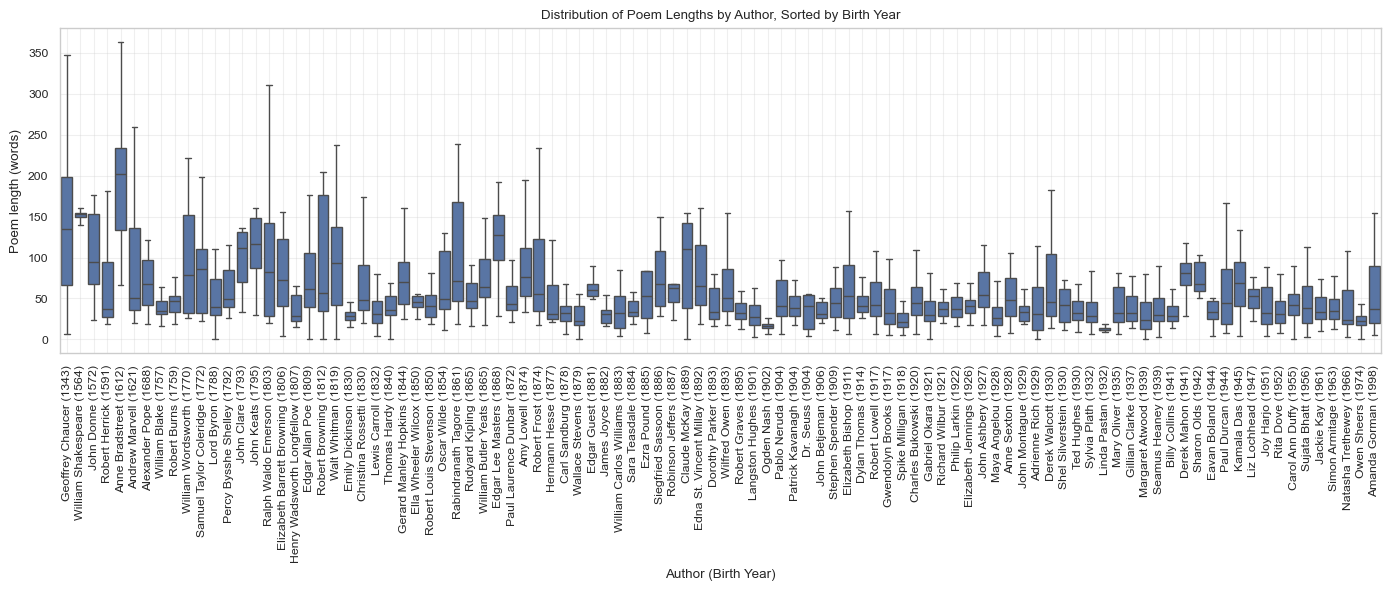

In [12]:
boxplot_poem_lengths(authors)

##### *Clarification: To calculate the trend, we remove time periods represented by fewer than the required number of authors so that the results are not distorted—for example, Geoffrey Chaucer is the only poet in the database who was born in the 14th century, so we do not have enough information about poetic trends in that century.*

In [13]:
representative_authors = clean_authors_dataset(authors, n_bins=8, min_authors_per_bin=5)
representative_metrics_df = compute_author_metrics(representative_authors)

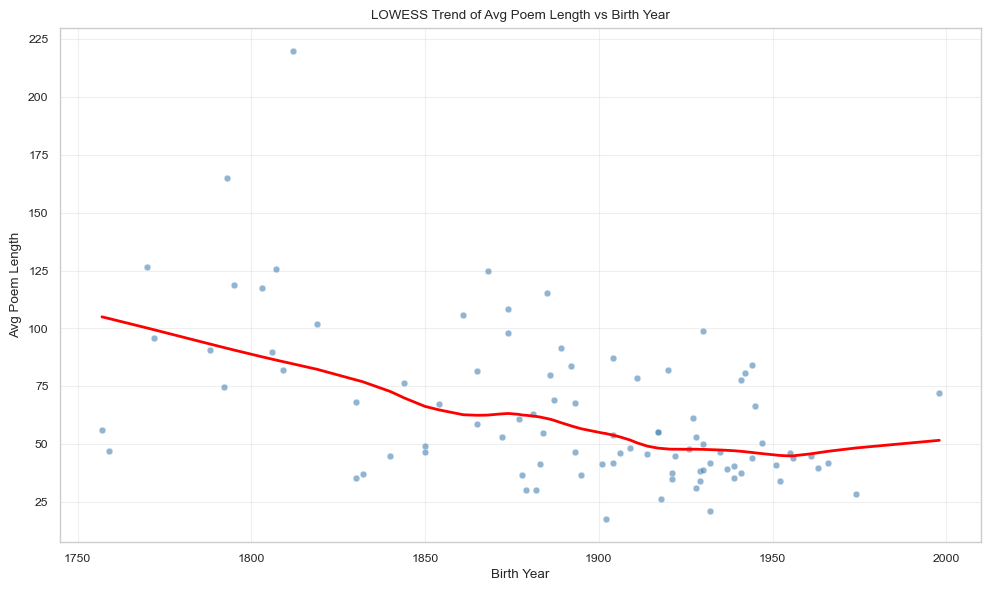

In [14]:
plot_trend_with_lowess(representative_metrics_df,
                       x_col="birth_year",
                       y_col = "avg_poem_length",
                       frac=0.5)

#### **Conclusions:** We can see that between 1750 and 1950, the average length of poems in the database decreased significantly.

#### **Most common words overall**

In [15]:
# Get top 20 most common words across all poems
common_all = most_common_words(authors, top_n=20)

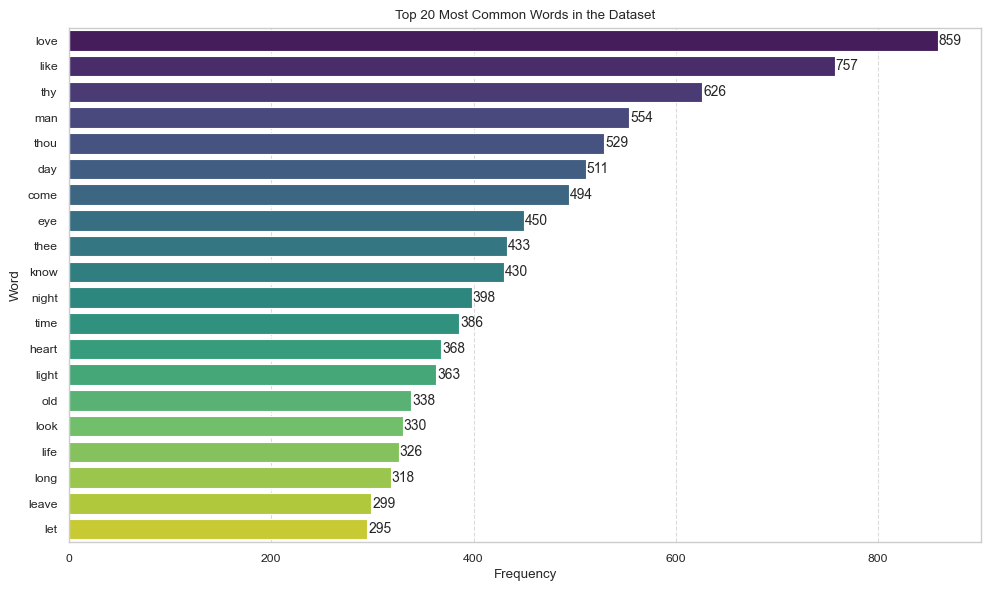

In [16]:
# Horizontal bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=common_all,
    x="count",
    y="word",
    palette="viridis",
    hue = "word",
    legend=False
)
# Add value labels to each bar
for i, (count, word) in enumerate(zip(common_all["count"], common_all["word"])):
    ax.text(
        count + 1,   # a little to the right of the bar
        i,             # vertical position matches the bar index
        str(count),
        va="center",
        ha="left",
        fontsize=10
    )

plt.xlabel("Frequency")
plt.ylabel("Word")
plt.title("Top 20 Most Common Words in the Dataset")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### **Scatter plots of authors by metrics**

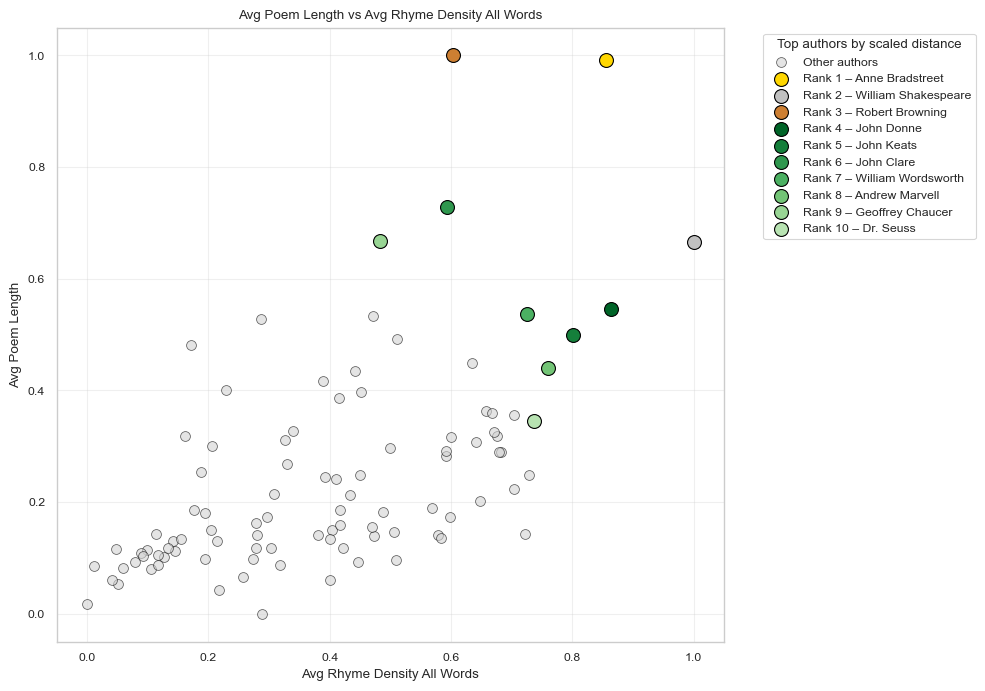

In [17]:
scatter_authors_by_metrics(metrics_df, "avg_rhyme_density_all_words", "avg_poem_length", top_n=10)

#### **Conclusion**: Although Shakespeare used the most rhymes in his poems and Robert Browning wrote the longest poems in terms of average length, when these two indicators are combined, Anne Bradstreet appears to be the most outstanding poet.

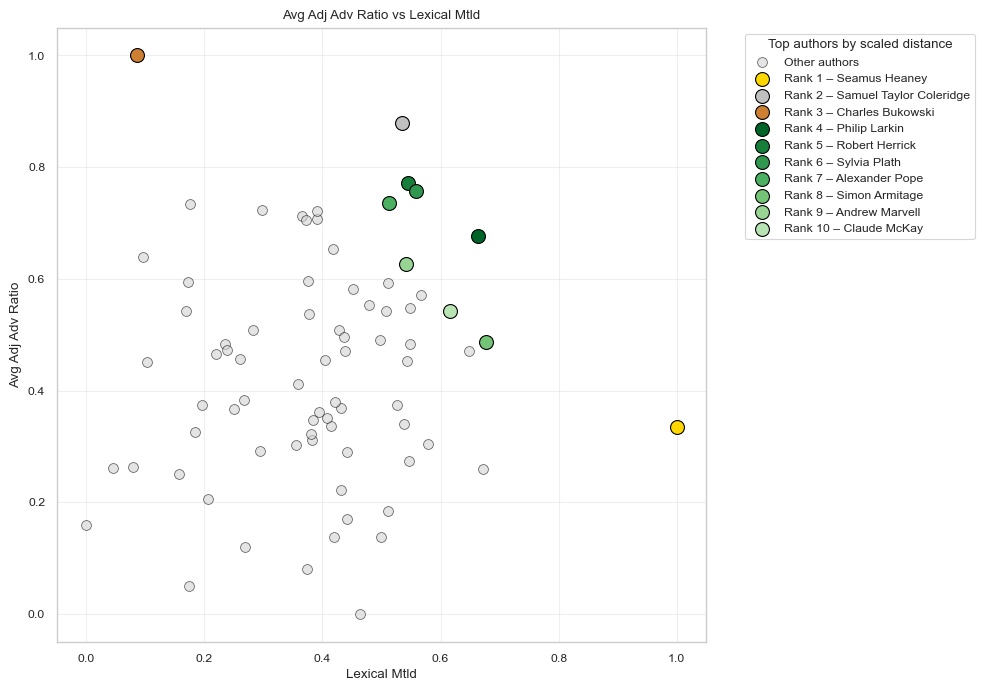

In [18]:
scatter_authors_by_metrics(metrics_df, "lexical_mtld", "avg_adj_adv_ratio", top_n = 10)

#### **Conclusion**: Charles Bukowski used the most descriptive language (based on his adjectives + adverbs ratio), while Seamus Heaney achieved the highest score on the coefficient responsible for measuring lexical diversity.

#### **Correlation heatmap of metrics**

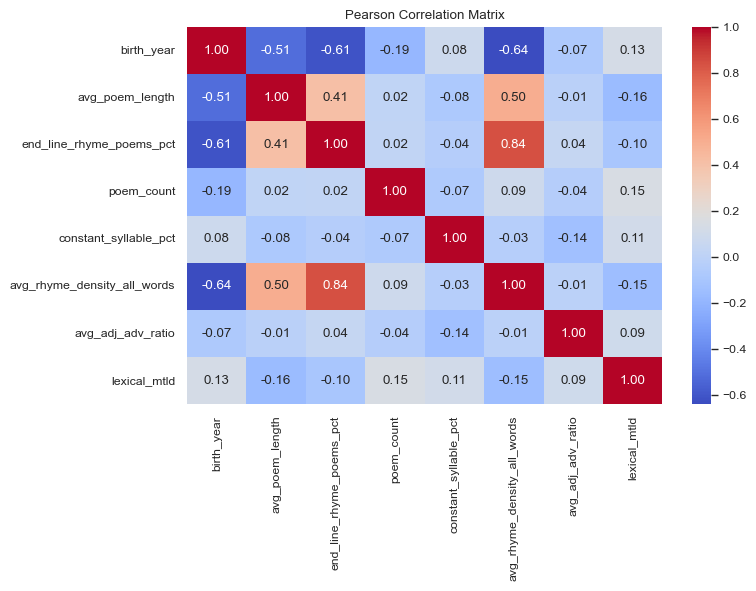

In [19]:
plot_correlation_heatmap(representative_metrics_df)

#### **Conclusions:** 
#### 1) The correlation table confirms the conclusions regarding the trend in line length—authors born later tended to write shorter lines. 
#### 2) Authors born earlier were more likely to adhere to the convention of placing rhymes at the end of lines and included more rhymes in their poems overall.
#### 3) Longer poems were more likely to rhyme, which is related to the two previous conclusions.

#### **Exemplary metric distribution**

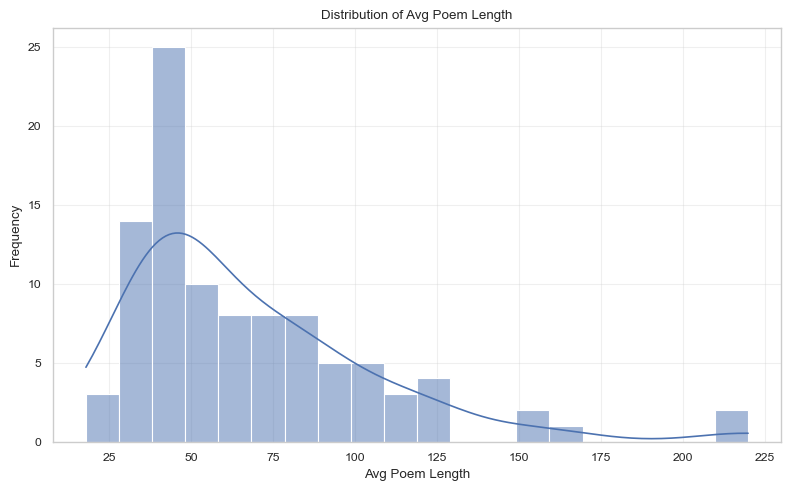

In [20]:
plot_metric_distribution(metrics_df, "avg_poem_length")

#### **Conclusion**: The vast majority of poems were between 25 and 70 words long.

#### **Detecting words popular during specific time period**

In [21]:
freq_df, bin_edges = detect_trendy_words(representative_authors, n_bins=6, min_count=5)
display(freq_df.head())

bin,0,1,2,3,4,5,6,std_dev
word,,,,,,,,
poem,0.000000,0.000360,0.000000,0.000175,0.000968,0.000582,0.019324,0.007181
woman,0.000195,0.001081,0.001136,0.000786,0.001937,0.001165,0.012077,0.004200
thy,0.009852,0.005584,0.002376,0.000437,0.000057,0.000000,0.000000,0.003791
like,0.008486,0.005704,0.008678,0.010041,0.012132,0.015725,0.014493,0.003560
come,0.003414,0.006305,0.007335,0.005675,0.005753,0.006407,0.014493,0.003494


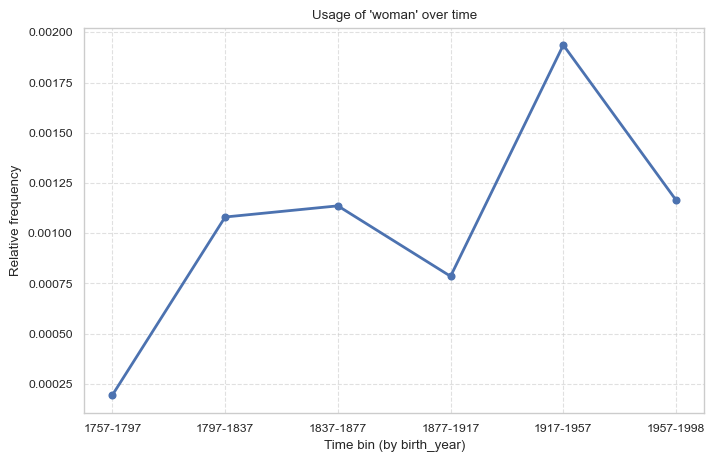

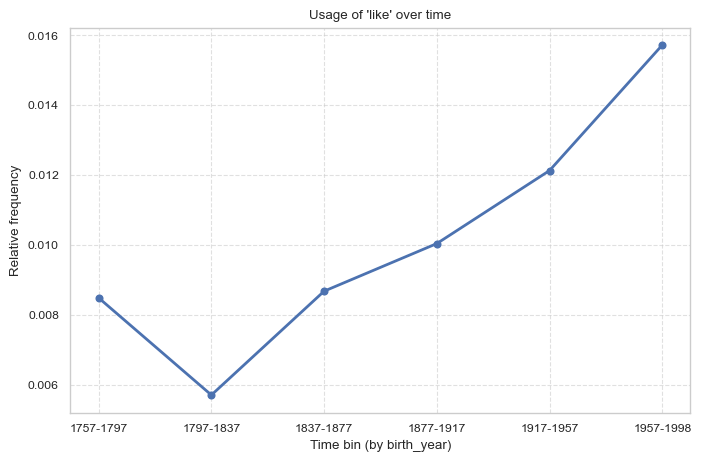

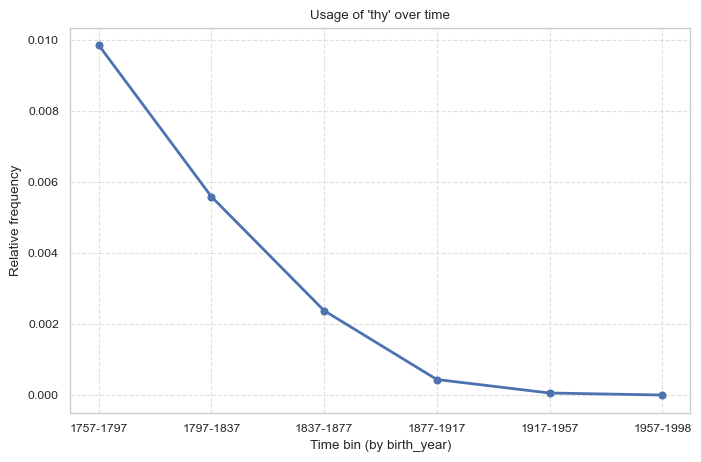

In [22]:
# Plot trend for a selected word
plot_word_trend(freq_df.index[1], freq_df, bin_edges)
plot_word_trend(freq_df.index[3], freq_df, bin_edges)
plot_word_trend(freq_df.index[2], freq_df, bin_edges)

#### **Conclusion:** It is clear that the popularity of words such as “woman” and "like" has increased, while the use of the word “thy” has declined over time and is now considered archaic.